In [1]:
from libs.ltspice_helper import convert_ltspice_step_simulation_data_to_csv

dataset_filename = "simulations_ltspice/simulation_optimization_dataset.csv"
datasets = [
    {"fsw": '40e3', "file": "simulations_ltspice/1_cuk_40khz_optimizing_components.txt"},
    {"fsw": '100e3', "file": "simulations_ltspice/1_cuk_100khz_optimizing_components.txt"},
]

convert_ltspice_step_simulation_data_to_csv(
    datasets=datasets, output_filename=dataset_filename)


In [2]:
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import cm
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset_filename = "simulations_ltspice/simulation_optimization_dataset.csv"
df = pd.read_csv(dataset_filename, low_memory=False)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace(np.nan, 0)
df_backup = df

df = df_backup[['fsw', 'Li', 'Cc', 'Lo', 'V(eff)']]
df = df.groupby(['fsw', 'Li', 'Cc', 'Lo']).mean().reset_index()
df


,fsw,Li,Cc,Lo,V(eff)
0,40000.0,0.000010,0.000001,0.000010,0.910923
1,40000.0,0.000010,0.000001,0.000022,0.929579
2,40000.0,0.000010,0.000001,0.000033,0.930403
3,40000.0,0.000010,0.000001,0.000047,0.930158
4,40000.0,0.000010,0.000002,0.000010,0.885167
...,...,...,...,...,...
67,100000.0,0.000033,0.000002,0.000047,0.897205
68,100000.0,0.000033,0.000005,0.000010,0.913789
69,100000.0,0.000033,0.000005,0.000022,0.903944
70,100000.0,0.000033,0.000005,0.000033,0.901002


In [3]:
def get_xyzv(df: pd.DataFrame, X: str, Y: str, Z: str, V: str):
    X = df[X].to_numpy()
    Y = df[Y].to_numpy()
    Z = df[Z].to_numpy()
    V = df[V].to_numpy()

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(), X.max(), 1000)
    yi = np.linspace(Y.min(), Y.max(), 1000)

    # Interpolate for plotting
    zi = griddata((X, Y), Z, (xi[None, :], yi[:, None]), method='nearest')
    vi = griddata((X, Y), V, (xi[None, :], yi[:, None]), method='nearest')

    xi, yi = np.meshgrid(xi, yi)

    return xi, yi, zi, vi


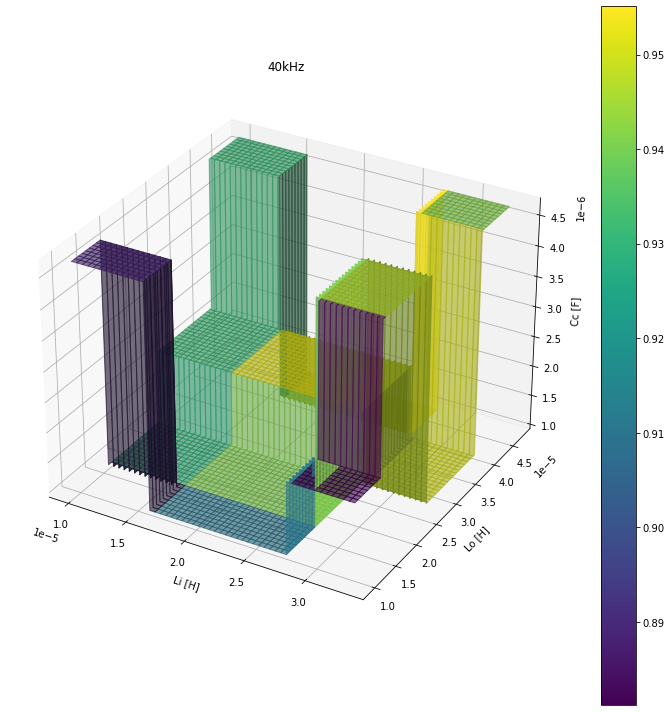

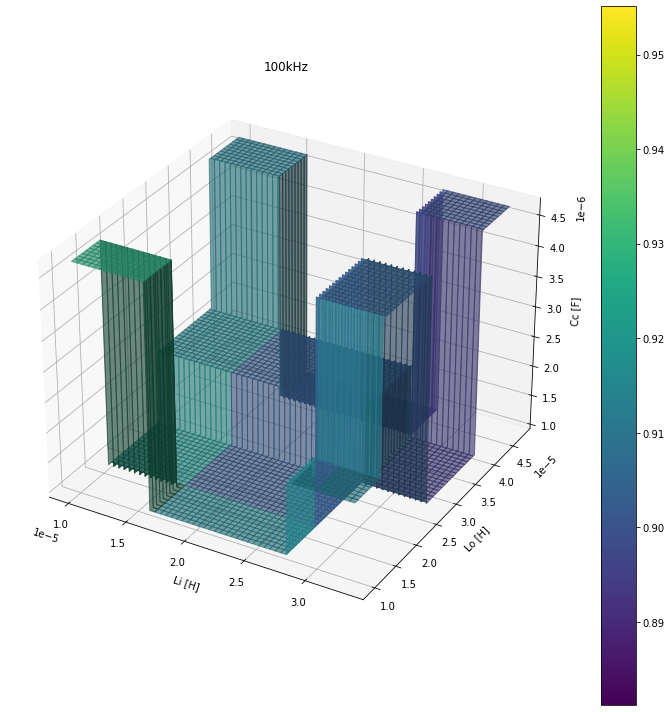

In [4]:
import matplotlib as mp

X1, Y1, Z1, V1 = get_xyzv(
    df.loc[df['fsw'] == 40000.0], 'Li', 'Lo', 'Cc', 'V(eff)')
X2, Y2, Z2, V2 = get_xyzv(
    df.loc[df['fsw'] == 100000.0], 'Li', 'Lo', 'Cc', 'V(eff)')
norm = plt.Normalize(vmin=min(V1.min().min(), V2.min().min()),
                     vmax=max(V1.max().max(), V2.max().max()))
colorbar = mp.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, Y1, Z1, facecolors=plt.cm.viridis(norm(V1)), alpha=0.6)
ax.set_xlabel('Li [H]')
ax.set_ylabel('Lo [H]')
ax.set_zlabel('Cc [F]')
plt.title("40kHz")
plt.colorbar(colorbar)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X2, Y2, Z2, facecolors=plt.cm.viridis(norm(V2)), alpha=0.6)
ax.set_xlabel('Li [H]')
ax.set_ylabel('Lo [H]')
ax.set_zlabel('Cc [F]')
plt.title("100kHz")
plt.colorbar(colorbar)
plt.tight_layout()
plt.show()
